# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, it's time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:
* Use modified sampling techniques to address class imbalance problems
* Understand the complications of class imbalance problems

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')


## Predicting Credit Card Fraud
Load the **creditcard.csv.gz** file and preview the data. To load a compressed csv, use the optional parameter `compression='gzip'` within pandas read_csv method as in: `pd.read_csv(filename, compression='gzip')`.

In [2]:



df = pd.read_csv('creditcard.csv.gz', compression= 'gzip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preview the class imbalance

You should see that the dataset has 31 columns. The first is a time field followed by V1-V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary Class flag. This last column, Class, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is.

In [3]:
print(df['Class'].value_counts())
df['Class'].value_counts(normalize=True)

0    284315
1       492
Name: Class, dtype: int64


0    0.998273
1    0.001727
Name: Class, dtype: float64

## Define the Problem

Define X and y and perform a standard train test split.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

X = df[df.columns[:-1]]
#Normalize the Data
X = X.apply(lambda x : (x - x.min()) /(x.max() - x.min()),axis=0)
y = pd.get_dummies(df.Class, drop_first=True)

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


## Create an initial model

As a baseline, fit a cookie cutter out of the box logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

In [5]:
logreg = LogisticRegression() #Starter code
model_log = logreg.fit(X_train, y_train)
print(model_log) #Preview model params
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
y_hat_test = logreg.predict(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
AUC: 0.9695803203811559


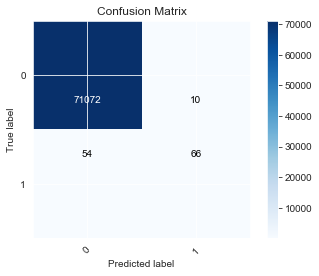

In [6]:
from sklearn.metrics import confusion_matrix

def confusion_plot(y_test, y_hat_test, y):
    cnf_matrix = confusion_matrix(y_test, y_hat_test)

    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

    #Add title and Axis Labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    #Add appropriate Axis Scales
    class_names = set(y) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    aa=[.25, .75]
    #Add Labels to Each Cell
    thresh = cnf_matrix.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment="center", position=(j,aa[i]),
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    pass
confusion_plot(y_test, y_hat_test, y[1])

## Tuning 
Try some of the various techniques proposed to tune your model. Compare your models using AUC, ROC or another metric.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.9691303705579472
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.9804015081173856
LogisticRegression(C=1.0, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn'

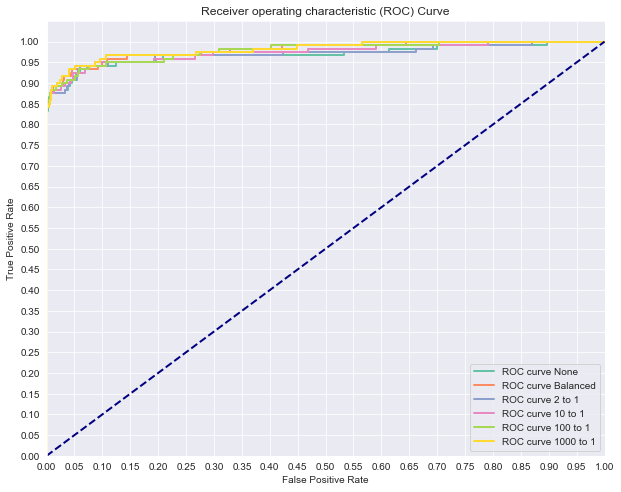

In [7]:
#Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette("Set2")
plt.figure(figsize=(10,8))
for n, weight in enumerate(weights):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, class_weight=weight) #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params
#Predict
    y_hat_test = logreg.predict(X_test)
    y_score = logreg.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



### SMOTE
If you haven't already, try using the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.

Using TensorFlow backend.


0    284315
1       492
Name: 1, dtype: int64
1    213233
0    213233
dtype: int64
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.9773447098656012
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.25: 0.9799615233111054
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, p

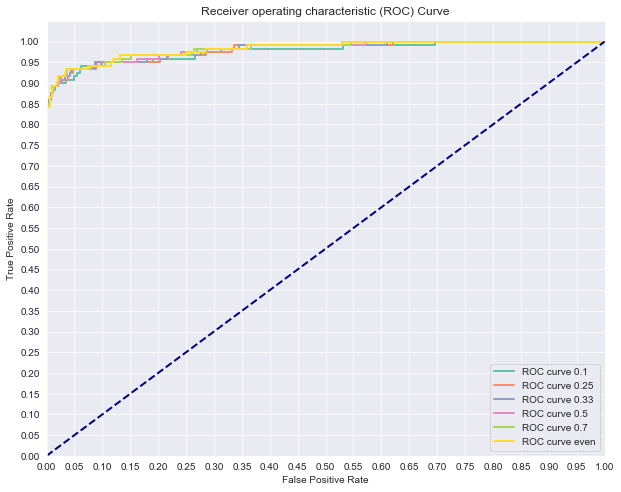

In [8]:
from imblearn.over_sampling import SMOTE
print(y[1].value_counts()) #Previous original class distribution

smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution


# Now let's compare a few different ratios of minority class to majority class
ratios = [0.1,0.25, 0.33, 0.5,0.7,1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette("Set2")
plt.figure(figsize=(10,8))
for n, ratio in enumerate(ratios):
    #Fit a model
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
    logreg = LogisticRegression(fit_intercept = False) #Starter code
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) #Preview model params
#Predict
    y_hat_test = logreg.predict(X_test)
    y_score = logreg.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Analysis
Describe what is misleading about the AUC score and ROC curves produced by this code:

In [ ]:
print(y[1].value_counts()) #Previous original class distribution
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c, solver='liblinear') #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

0    284315
1       492
Name: 1, dtype: int64
1    284315
0    284315
dtype: int64
LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.9821380887010818
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.9863964578347884
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n

## Your response here

In [ ]:
# This ROC curve is misleading because the test set was also manipulated using SMOTE. 
# This produces results that will not be comparable to future cases as we have synthetically created test cases. 
# SMOTE should only be applied to training sets, and then from there, an accurate gauge can be made on the model's performance 
# by using a raw test sample that has not been oversampled or undersampled.

## Summary

In this lab, you got some hands-on practice tuning logistic regression models using various techniques and parameters. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.